In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import h5py
from scipy.optimize import minimize

from density_pericenter_fit_utils import log_likelihood, run_mcmc, log_model
from density_profile_fit_utils import fit_nfw_model, fit_isothermal_model, fit_core_nfw_model

plt.style.use("pltstyle.mplstyle")

In [3]:
DATA_PATH = "../data/TangoSIDM/"

IDs = {
    "SigmaConstant00": "CDM",
    "SigmaConstant01": "SigmaConstant01",
    "SigmaConstant10": "SigmaConstant10",
    "SigmaVelDep20Anisotropic": "SigmaVel20",
    "SigmaVelDep60Anisotropic": "SigmaVel60", 
    "SigmaVelDep100Anisotropic": "SigmaVel100",
}

In [4]:
def run_best_fit(r_p, rho_150pc):
    # Prepare arrays ..
    x = np.log10(r_p[0, :])
    xerr = r_p[1, :]

    y = np.log10(rho_150pc[0, :] / 1e7)
    yerr = rho_150pc[1, :] / 1e7

    # Make initial fit ..
    np.random.seed(42)
    nl = lambda *args: -log_likelihood(*args)
    initial = np.array([0, 0.])
    soln = minimize(nl, initial, args=(x, y, xerr, yerr))
    q, m = soln.x
    print('=======')
    print(q, m)

    samples = run_mcmc(x, y, xerr, yerr, soln)
    
    return samples


def get_q_m_from_samples(samples):
    q = np.median(samples[:, 0])
    m = np.median(samples[:, 1])
    qerrl = np.percentile(samples[:, 0], 16)
    qerrh = np.percentile(samples[:, 0], 84)
    merrl = np.percentile(samples[:, 1], 16)
    merrh = np.percentile(samples[:, 1], 84)
    return np.array([q, m, qerrl, qerrh, merrl, merrh])

## Fit density at 150pc (estimated with NFW) vs pericenter

0.0 0.0


100%|██████████| 5000/5000 [00:07<00:00, 682.49it/s]


Multiprocessing took 0.1 minutes
Mean autocorrelation time: 50.519 steps
1.2830480373562618 -0.0743536909554702


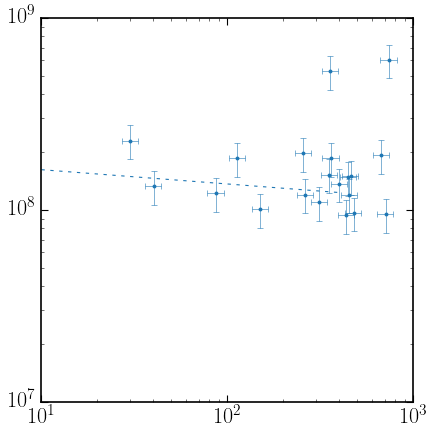

0.0 0.0


100%|██████████| 5000/5000 [00:07<00:00, 662.56it/s]


Multiprocessing took 0.1 minutes
Mean autocorrelation time: 36.675 steps
-3.703251931234717 1.8657277589577768


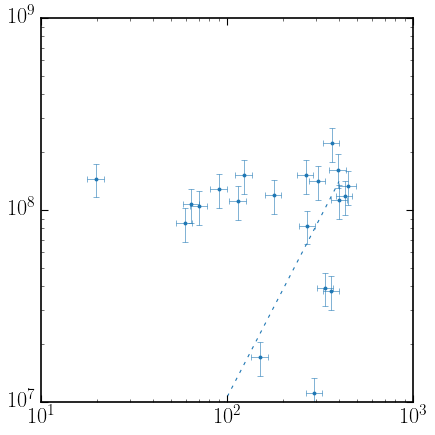

0.0 0.0


100%|██████████| 5000/5000 [00:07<00:00, 700.68it/s]


Multiprocessing took 0.1 minutes
Mean autocorrelation time: 38.784 steps
-1.5774511551598067 0.9305954885910412


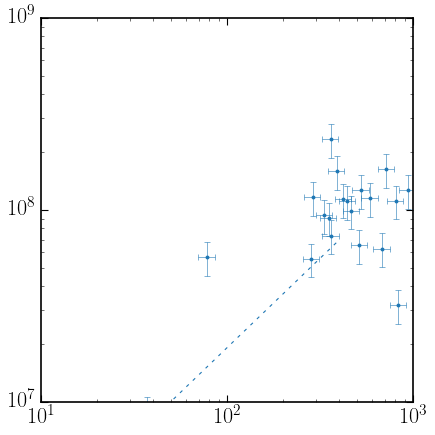

0.0 0.0


100%|██████████| 5000/5000 [00:07<00:00, 705.14it/s]


Multiprocessing took 0.1 minutes
Mean autocorrelation time: 46.901 steps
1.3569053075223187 -0.1285542048297792


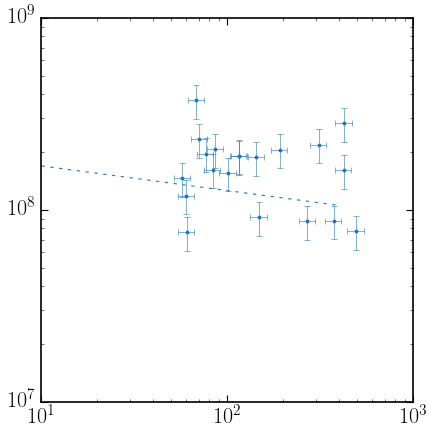

0.0 0.0


100%|██████████| 5000/5000 [00:07<00:00, 672.84it/s]


Multiprocessing took 0.1 minutes
Mean autocorrelation time: 30.798 steps
-1.9746860378573152 1.1668578216171626


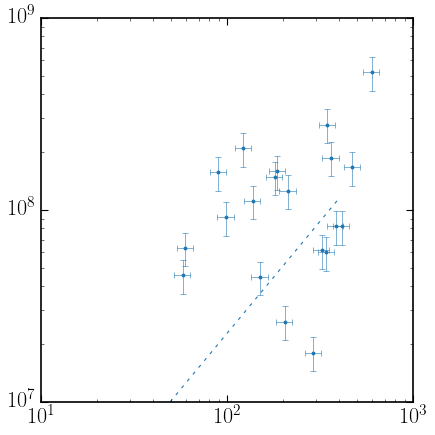

0.0 0.0


100%|██████████| 5000/5000 [00:07<00:00, 688.73it/s]


Multiprocessing took 0.1 minutes
Mean autocorrelation time: 64.565 steps
2.1055141131013686 -0.5113478793418771


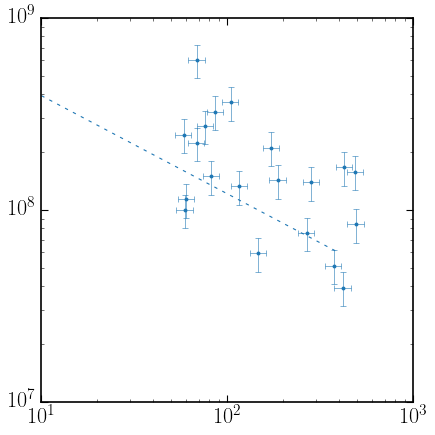

In [5]:
for i, (id, id_name) in enumerate(IDs.items()):
    file = h5py.File(DATA_PATH+f"{id}.hdf5", "a")
    
    # Get halo data
    density = []
    for idx in file.keys():
        
        # Get MW halos
        if file[f'{idx}'].attrs.get("main_halo_of") is not None:   
            subhalo_idxs = file[f'{idx}'].attrs.get("main_halo_of")
            rp, rho150, error_rho150 = [], [], []
            
            # Get satellites of MW halo
            for subhalo_idx in subhalo_idxs:
                data_subhalo = file[f'{subhalo_idx}']
                
                # Get pericenter
                _rp = data_subhalo["tree_data"]["pericenter"][1]
                _rp = _rp[0] if _rp.shape==(1,) else _rp
                rp.append(_rp)
                
                # Get NFW fit at 150 pc
                r_s, log10_rho_s, sigma_r_s, sigma_log10_rho_s = data_subhalo["halo_data"]["nfw_fit"][:]
                rho_s = 10**log10_rho_s
                sigma_rho_s = rho_s * np.log(10) * sigma_log10_rho_s /2
                r150 = np.array([0.15])
                _rho_150 = 10**fit_nfw_model(r150, r_s, log10_rho_s)
                rho150.append(_rho_150)
                
                # Errors
                _error_rho150 = (sigma_rho_s / rho_s)**2
                _error_rho150 += ((sigma_r_s / r_s) * ((3. + r_s / r150) / (1. + r_s / r150)) )**2
                _error_rho150 *= _rho_150**2
                error_rho150.append(np.sqrt(_error_rho150))
            
            # Fit
            rp = np.array(rp)
            rp = np.float32(np.stack((rp, rp/10)))
            rho150 = np.array(rho150)
            error_rho150 = np.array(error_rho150)
            # rho150 = np.float32(np.concatenate((rho150.T, error_rho150.T)))
            rho150 = np.float32(np.stack((rho150[:, 0], rho150[:, 0]/5)))
            samples = run_best_fit(rp, rho150)
            fit = get_q_m_from_samples(samples)
            
            # Save fit
            # file[f'{idx}'].require_dataset("satellite_rho150nfw_rp_fit", data=fit, shape=fit.shape, dtype=fit.dtype)
            
            # Plot
            q, m, qerrl, qerrh, merrl, merrh = fit
            print(q, m)
            plt.errorbar(rp[0,:], rho150[0,:], xerr=rp[1:,:], yerr=rho150[1:,:],marker='o', markersize=3.5, markeredgecolor="none", ls='none', lw=0.5, c='tab:blue')
            plt.xscale('log')
            plt.yscale('log')
            xrange = np.arange(np.log10(10), np.log10(500), 0.2)
            num_range = len(xrange) 
            yrange = np.ones((2,num_range))
            # for i in range(num_range):
            #     yrange[0, i] = np.percentile(1e7 * 10 ** log_model(xrange[i], samples[:, 0], samples[:, 1]), 16)
            #     yrange[1, i] = np.percentile(1e7 * 10 ** log_model(xrange[i], samples[:, 0], samples[:, 1]), 84)
            # plt.fill_between(10 ** xrange, yrange[0,:], yrange[1,:], alpha=0.1)
            plt.loglog(10 ** xrange, 1e7 * 10 ** log_model(xrange, q, m), '--', lw=1)
            plt.axis([10, 1e3, 1e7, 1e9])
            plt.show()
            break
        
    file.close()